09/14/22 The purpose of this file is to see if weighting the ranking will perform better (like tfidf). 

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline 
os.chdir("../..")
from datasets.hsqc_folder_dataset import FolderDataset
from models.compute_metrics import cm
from models.ranked_transformer import HsqcRankedTransformer
from models.ranked_double_transformer import DoubleTransformer
from datasets.hsqc_folder_dataset import FolderDataModule
import re

In [36]:
import importlib
import utils.ranker
importlib.reload(utils.ranker)
from utils.ranker import RankingSet

In [2]:
path = "/workspace/smart4.5/tempdata/hyun_fp_data/hsqc_ms_pairs"
train = FolderDataset(dir = path, split="train", input_src=["HSQC"])

In [3]:
import torch
from tqdm import tqdm
def accumulate_fp(store,ds):
    ds_len = len(ds)
    for i in tqdm(range(ds_len)):
        hsqc, fp = ds[i]
        store[:] += fp
base = torch.zeros(6144)
accumulate_fp(base, train)

100%|██████████| 9794/9794 [00:07<00:00, 1377.02it/s]


(array([3166.,  243.,   69.,  113.,  199.,    0.,    0.,    0.,    0.,
        2354.]),
 array([1.02092905e-04, 1.00091882e-01, 2.00081676e-01, 3.00071478e-01,
        4.00061250e-01, 5.00051022e-01, 6.00040853e-01, 7.00030625e-01,
        8.00020397e-01, 9.00010228e-01, 1.00000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

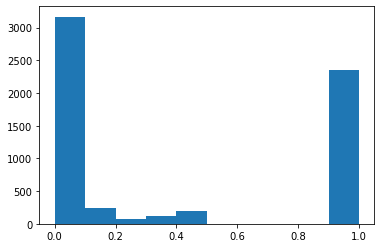

In [4]:
idf = 1/(base + 1)
from matplotlib import pyplot as plt
plt.hist(idf.numpy())

In [5]:
folder = "/data/smart4.5/pre_exp_v2/"
path = "j1_both_pair_[09_07_2022_06:23]_[bs=128_epochs=300_lr=1e-05_hsqc_heads=8_hsqc_layers=8_ms_heads=8_ms_layers=8_dropout=0.3_fc_dim=256_hsqc_dim_coords=112,112,32_hsqc_dim_model=256_hsqc_dropout=0_hsqc_ff_dim=1024_hsqc_lr=0.001_hsqc_out_dim=6144]"
chkpt = next((f for f in os.listdir(os.path.join(folder, path, "checkpoints")) if re.search("epoch", f)), None)
full_path = os.path.join(folder, path, "checkpoints", chkpt) if chkpt is not None else None
print(full_path)

/data/smart4.5/pre_exp_v2/j1_both_pair_[09_07_2022_06:23]_[bs=128_epochs=300_lr=1e-05_hsqc_heads=8_hsqc_layers=8_ms_heads=8_ms_layers=8_dropout=0.3_fc_dim=256_hsqc_dim_coords=112,112,32_hsqc_dim_model=256_hsqc_dropout=0_hsqc_ff_dim=1024_hsqc_lr=0.001_hsqc_out_dim=6144]/checkpoints/epoch=299-step=23100.ckpt


In [37]:
print(idf is not None, idf)
ranker = RankingSet(file_path="./tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", idf_weights=idf)

True tensor([1.0000e+00, 3.3568e-04, 1.0000e+00,  ..., 4.0000e-02, 3.1250e-02,
        2.1739e-02])


In [19]:
model = DoubleTransformer.load_from_checkpoint(full_path).cuda()
model.eval()

In [21]:
my_dir = f"/workspace/smart4.5/tempdata/hyun_fp_data/hsqc_ms_pairs"
dm = FolderDataModule(dir=my_dir, do_hyun_fp=True, input_src=["HSQC", "MS"], batch_size=128)
dm.setup("fit")
val_dl = dm.val_dataloader()

In [40]:
import tqdm
ranks = []
ranks_idf = []
with torch.no_grad():
  for batch in tqdm.tqdm(val_dl):
    hsqc, ms, fp = batch
    hsqc, ms, fp = hsqc.cuda(), ms.cuda(), fp.cuda()
    out = torch.sigmoid(model.forward(hsqc, ms))
    out = (out >= 0.5).type(torch.FloatTensor)

    cts = [1, 5, 10]
    rank_res = ranker.batched_rank(out, fp)
    rank_res_idf = ranker.batched_rank_tfidf(out, fp)
    ranks.append(rank_res.float().mean().item())
    ranks_idf.append(rank_res_idf.float().mean().item())


 10%|█         | 1/10 [00:02<00:19,  2.19s/it]

torch.Size([128, 6144]) torch.Size([6144])


 20%|██        | 2/10 [00:03<00:11,  1.43s/it]

torch.Size([128, 6144]) torch.Size([6144])


 30%|███       | 3/10 [00:03<00:08,  1.19s/it]

torch.Size([128, 6144]) torch.Size([6144])


 40%|████      | 4/10 [00:04<00:05,  1.00it/s]

torch.Size([128, 6144]) torch.Size([6144])


 50%|█████     | 5/10 [00:05<00:04,  1.08it/s]

torch.Size([128, 6144]) torch.Size([6144])


 60%|██████    | 6/10 [00:05<00:03,  1.28it/s]

torch.Size([128, 6144]) torch.Size([6144])


 70%|███████   | 7/10 [00:06<00:02,  1.45it/s]

torch.Size([128, 6144]) torch.Size([6144])


 80%|████████  | 8/10 [00:07<00:01,  1.51it/s]

torch.Size([128, 6144]) torch.Size([6144])
torch.Size([128, 6144]) torch.Size([6144])


100%|██████████| 10/10 [00:08<00:00,  1.65it/s]

torch.Size([72, 6144]) torch.Size([6144])


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [42]:
print("mean_rank", torch.mean(torch.tensor(ranks)))
print("ranks_idf", torch.mean(torch.tensor(ranks_idf)))

mean_rank tensor(106.8411)
ranks_idf tensor(239.6143)
